In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext(master='local',appName="Linear Regression")
spark = SparkSession(sparkContext=sc)

In [16]:
import numpy as np
import matplotlib.pyplot as plt 

# Gradient Descent in Python

### Generate data

In [17]:
size= 1000
x1 = np.random.rand(size)
x2 = np.random.rand(size)
beta0 = 0
beta1 = 1
beta2 = 4
x = []
for i in range(size):
    x.append(np.array([x1[i],x2[i]]))
e = np.random.rand(size)*0.2
y = beta0 + beta1*x1 + beta2*x2 + e

### Data visualisation

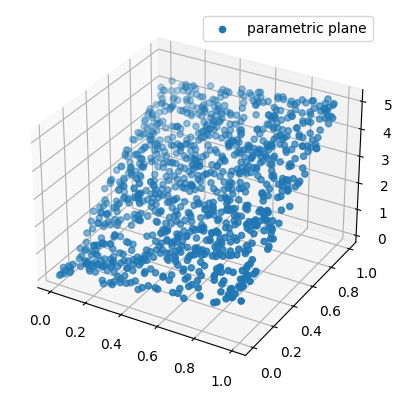

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
 
mpl.rcParams['legend.fontsize'] = 10
 
fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')

ax.scatter3D(x1, x2, y, label='parametric plane' )
ax.legend()
 
plt.show()

### Gradient Descent Algorithm

In [20]:
learningRate = 1
num_iteration = 100
m_current=np.zeros(2)
n = float(size)
# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    # Calculate the prediction with current regression coefficients. 
    cost = 0
    m_gradient = 0
    for j in range(size):
        y_prediction = np.dot(m_current,x[j])
        # We compute costs just for monitoring 
        cost += ( y[j] - y_prediction)**2
        # calculate gradients.
        m_gradient += x[j] * (y[j] - y_prediction)
    m_gradient = (-1.0/n)* m_gradient
    # update the weights - Regression Coefficients 
    m_current = m_current - learningRate * m_gradient
    print(i , "m=", m_current, " Cost=", cost/n)

0 m= [1.35261233 1.65207791]  Cost= 8.226412913631648
1 m= [1.86657366 2.41138442]  Cost= 1.717867421806958
2 m= [2.02945129 2.78690686]  Cost= 0.5083153646100882
3 m= [2.04782995 2.99512358]  Cost= 0.2595856168881331
4 m= [2.00903913 3.12829839]  Cost= 0.18887734295431968
5 m= [1.94981028 3.22593132]  Cost= 0.1543373008689457
6 m= [1.88542214 3.30509475]  Cost= 0.129754463068119
7 m= [1.82207183 3.37331472]  Cost= 0.10986224548330277
8 m= [1.76212472 3.43404155]  Cost= 0.09325456855110849
9 m= [1.70634132 3.48897425]  Cost= 0.07929322384304562
10 m= [1.65482083 3.53904907]  Cost= 0.06753910188842949
11 m= [1.6074001  3.58486074]  Cost= 0.05764010327471202
12 m= [1.5638215 3.6268428]  Cost= 0.049302870982511876
13 m= [1.52380277 3.66534544]  Cost= 0.04228090262300292
14 m= [1.48706542 3.70066982]  Cost= 0.036366686531404395
15 m= [1.45334562 3.73308371]  Cost= 0.03138546566490897
16 m= [1.42239772 3.76282922]  Cost= 0.027190055067915653
17 m= [1.39399481 3.79012701]  Cost= 0.0236564894

# Gradient Descent in PySpark

### Generate data
- Data range infulence the learning rate (Try to change scale_x)
- Intercept calculation (adding 1 to the input data)

In [30]:
#Data set parameters
size  = 10000 # Size of input data
scale_x = 1 # Scaling of the input data (default range is [0,1])
d = 3 # Dimensionality of the input data
theta = [-1,1,2] # The parameters of the model
theta0 = 0 # The intercept value
error_rate = 0.1

# Create random input varaiables
x = np.random.rand(size,d)
# Scale the input space
x = x*scale_x
# Generate errors for each sample
e = np.random.rand(size)*scale_x*error_rate
# Create the data
data = []
for i in range(size):
    # Calculate the target variable
    y = np.dot(theta,x[i]) + theta0 +e[i]
    # Create a tuple (target_variable, array[input_varaiables]) 
    data.append((y,x[i]))

myRDD = sc.parallelize(data)
# Needed for intercept calculation
# myRDD= myRDD.map(lambda x: (x[0],np.append(x[1],1 )))
myRDD.cache()

PythonRDD[190] at RDD at PythonRDD.scala:53

In [31]:
myRDD.take(3)

[(5.607546468378349, array([0.85462516, 0.58859646, 0.92123769, 1.        ])),
 (5.782912959135288, array([0.56222564, 0.90712504, 0.69178533, 1.        ])),
 (6.469210075100727, array([0.2804658 , 0.69288465, 0.98110112, 1.        ]))]

### Gradient Descent Algorithm

In [33]:
learningRate = 1
num_iteration = 30

# Calculate the dimensionality of the inpit data
d_input = len(myRDD.first()[1])
beta = np.zeros(d_input)
print(f"Input dimensionalyty is {d_input} and we start wiht {beta} as parameters ")

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    gradientAndCost=myRDD.map(lambda x: (x[1], (x[0] - np.dot(x[1] , beta) )))\
                           .map(lambda x: (x[0]*x[1], x[1]**2 ))\
                           .reduce(lambda x, y: (x[0] +y[0], x[1]+y[1] ))
    cost= gradientAndCost[1]/size
    gradient=(-1/float(size))* gradientAndCost[0]
    beta = beta - learningRate * gradient
    print(f"{i} Cost:{cost:.5f} Beta {beta}")

Input dimensionalyty is 4 and we start wiht [0. 0. 0. 0.] as parameters 
0 Cost:25.95541 Beta [2.44616236 2.58751643 2.689921   5.04526563]
1 Cost:16.08304 Beta [0.23118549 0.54669658 0.7028668  1.18955255]
2 Cost:9.99911 Beta [1.69213165 2.1322325  2.36971358 4.30652977]
3 Cost:6.24547 Beta [0.29216808 0.87386294 1.16131228 1.95364162]
4 Cost:3.92584 Beta [1.15366699 1.8436132  2.19661327 3.88430789]
5 Cost:2.48916 Beta [0.25993259 1.06593375 1.46398978 2.45338165]
6 Cost:1.59657 Beta [0.75814526 1.65729168 2.10883888 3.65376596]
7 Cost:1.03965 Beta [0.18011021 1.17497721 1.66637334 2.78802154]
8 Cost:0.69013 Beta [0.45940518 1.53388271 2.06934394 3.53844436]
9 Cost:0.46904 Beta [0.07932121 1.23312859 1.80338215 3.01877631]
10 Cost:0.32770 Beta [0.22777805 1.4493097  2.05612596 3.4915861 ]
11 Cost:0.23609 Beta [-0.02728058  1.26023884  1.89716485  3.18347188]
12 Cost:0.17567 Beta [0.04392612 1.38886933 2.05629714 3.48466573]
13 Cost:0.13494 Beta [-0.13140537  1.26858153  1.96190545  3